In [33]:
picture dataset used

Google image searches

goal celebration
goal scorer celebrate
sports celebration

SyntaxError: invalid syntax (<ipython-input-33-0d1b134febb2>, line 1)

In [34]:
# Importing the libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

# Setting some hyperparameters
batchSize = 64 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).

In [35]:
# Creating the transformations
transform = transforms.Compose([transforms.Resize(imageSize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.


In [36]:
#dataset = dset.CIFAR10(root = './data/goal', transform = transform) # We download the training set in the ./data folder and we apply the previous transformations on each image.


In [37]:


# Loading the dataset
dataset = dset.CIFAR10(root = './data', download = True, transform = transform) # We download the training set in the ./data folder and we apply the previous transformations on each image.
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) # We use dataLoader to get the images of the training set batch by batch.


Files already downloaded and verified


In [38]:
# Really good tutorial on datasets for images in pytorch. 
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [39]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [40]:
def show_image(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

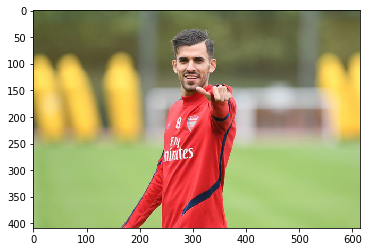

In [41]:
plt.figure()
show_image(io.imread(os.path.join('data/goal/', '0_Ceballos.jpg')))
plt.show()

In [42]:
import glob
print((glob.glob("data/goal/*.jpg")))

['data/goal\\-figure-football-1-bundesliga-21st-matchday-eintracht-frankfurt-f-fc-augsburg-a-5-0-on-february-7-2020-in-frankfurtgermany-usage-worldwide-2AX0278.jpg', 'data/goal\\000_1E62W0.jpg', 'data/goal\\0011c5d8-1600.jpg', 'data/goal\\0_19713553.jpg', 'data/goal\\0_bogle-celebrate.jpg', 'data/goal\\0_Ceballos.jpg', 'data/goal\\0_DSC_2035jpeg.jpg', 'data/goal\\0_England-v-USA-FIFA-Womens-World-Cup-2019-Semi-Final-Stade-de-Lyon.jpg', 'data/goal\\0_GettyImages-1203587983.jpg', 'data/goal\\0_GettyImages-1206696508.jpg', 'data/goal\\0_Sky-Bet-EFL-Championship-Football-Huddersfield-Town-v-Leeds-United-071219.jpg', 'data/goal\\10-2.jpg', 'data/goal\\102816907.jpg', 'data/goal\\1036073_1.jpg', 'data/goal\\1120.jpg', 'data/goal\\1148143.jpg', 'data/goal\\11wwc-live8-promo2-superJumbo-v3.jpg', 'data/goal\\1220.jpg', 'data/goal\\12427022-0-image-a-32_1555580778872.jpg', 'data/goal\\1252300_original.jpg', 'data/goal\\12590760-6948747-Gonzalo_Higuain_rushed_to_celebrate_with_the_Chelsea_fans_af

In [43]:
file_list = os.listdir('data/goal')

In [44]:
file_list

['-figure-football-1-bundesliga-21st-matchday-eintracht-frankfurt-f-fc-augsburg-a-5-0-on-february-7-2020-in-frankfurtgermany-usage-worldwide-2AX0278.jpg',
 '000_1E62W0.jpg',
 '0011c5d8-1600.jpg',
 '0_19713553.jpg',
 '0_bogle-celebrate.jpg',
 '0_Ceballos.jpg',
 '0_DSC_2035jpeg.jpg',
 '0_England-v-USA-FIFA-Womens-World-Cup-2019-Semi-Final-Stade-de-Lyon.jpg',
 '0_GettyImages-1203587983.jpg',
 '0_GettyImages-1206696508.jpg',
 '0_Sky-Bet-EFL-Championship-Football-Huddersfield-Town-v-Leeds-United-071219.jpg',
 '10-2.jpg',
 '102816907.jpg',
 '1036073_1.jpg',
 '1120.jpg',
 '1148143.jpg',
 '11wwc-live8-promo2-superJumbo-v3.jpg',
 '1220.jpg',
 '12427022-0-image-a-32_1555580778872.jpg',
 '1252300_original.jpg',
 '12590760-6948747-Gonzalo_Higuain_rushed_to_celebrate_with_the_Chelsea_fans_after_-a-28_1555976547350.jpg',
 '12792054-0-image-a-16_1556377953368.jpg',
 '13619-1496828986013.jpg',
 '1483526630-giroud.jpg',
 '1575743524_726129_noticia_normal.jpg',
 '163F46E000000514-0-image-m-13_1494257892

In [45]:
class celebrationDataset(Dataset):
    """Dataset of goal celebrations"""

    def __init__(self,file_list, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        #get all file names in the root dir
        self.picture_names = file_list
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.picture_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.picture_names[idx])
        image = io.imread(img_name)

        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (956, 1300, 3)


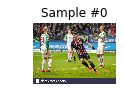

1 (512, 768, 3)


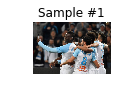

2 (900, 1600, 3)


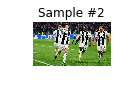

3 (409, 615, 3)


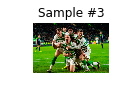

In [46]:
goal_celebration_dataset = celebrationDataset(file_list=file_list,
                                    root_dir='data/goal/')

fig = plt.figure()

for i in range(len(goal_celebration_dataset)):
    sample = goal_celebration_dataset[i]

    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(**sample)

    if i == 3:
        plt.show()
        break

In [47]:
from skimage import io, transform

In [48]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image= sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image= sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}

In [49]:
sample = goal_celebration_dataset[10]

In [50]:
sample

{'image': array([[[ 33,  46,  80],
         [ 39,  52,  86],
         [ 35,  48,  82],
         ...,
         [125, 113, 115],
         [120, 110, 111],
         [118, 108, 109]],
 
        [[ 31,  46,  79],
         [ 35,  50,  83],
         [ 29,  44,  77],
         ...,
         [121, 111, 110],
         [119, 109, 108],
         [116, 107, 108]],
 
        [[ 30,  45,  78],
         [ 34,  49,  82],
         [ 27,  42,  75],
         ...,
         [121, 111, 109],
         [119, 111, 108],
         [118, 110, 108]],
 
        ...,
 
        [[ 92, 153, 255],
         [ 76, 137, 244],
         [ 72, 128, 237],
         ...,
         [115, 144, 222],
         [112, 141, 219],
         [112, 141, 219]],
 
        [[101, 164, 255],
         [ 83, 144, 251],
         [ 77, 135, 243],
         ...,
         [113, 146, 225],
         [110, 143, 222],
         [109, 142, 223]],
 
        [[ 98, 162, 255],
         [ 83, 146, 252],
         [ 74, 135, 242],
         ...,
         [108, 143,

In [51]:
to_t = ToTensor()

In [52]:
to_t(sample)

{'image': tensor([[[ 33,  39,  35,  ..., 125, 120, 118],
          [ 31,  35,  29,  ..., 121, 119, 116],
          [ 30,  34,  27,  ..., 121, 119, 118],
          ...,
          [ 92,  76,  72,  ..., 115, 112, 112],
          [101,  83,  77,  ..., 113, 110, 109],
          [ 98,  83,  74,  ..., 108, 108, 108]],
 
         [[ 46,  52,  48,  ..., 113, 110, 108],
          [ 46,  50,  44,  ..., 111, 109, 107],
          [ 45,  49,  42,  ..., 111, 111, 110],
          ...,
          [153, 137, 128,  ..., 144, 141, 141],
          [164, 144, 135,  ..., 146, 143, 142],
          [162, 146, 135,  ..., 143, 144, 144]],
 
         [[ 80,  86,  82,  ..., 115, 111, 109],
          [ 79,  83,  77,  ..., 110, 108, 108],
          [ 78,  82,  75,  ..., 109, 108, 108],
          ...,
          [255, 244, 237,  ..., 222, 219, 219],
          [255, 251, 243,  ..., 225, 222, 223],
          [255, 252, 242,  ..., 224, 222, 222]]], dtype=torch.uint8)}

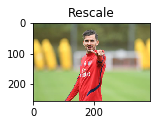

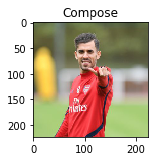

In [53]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = goal_celebration_dataset[5]
for i, tsfrm in enumerate([scale, composed]):
    
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_image(**transformed_sample)

plt.show()

In [54]:
transformed_dataset = celebrationDataset(file_list=file_list,
                                    root_dir='data/goal/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               ToTensor()
                                           ]))

In [55]:
transformed_dataset[0]['image'].shape

torch.Size([3, 256, 348])

In [56]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size())

    if i == 3:
        break

0 torch.Size([3, 256, 348])
1 torch.Size([3, 256, 384])
2 torch.Size([3, 256, 455])
3 torch.Size([3, 256, 384])


In [57]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
goal_dataset = datasets.ImageFolder(root=r'C:\Users\awalker8\Documents\COVID_Furlow\Module 3 - GANs\data',
                                           transform=data_transform)
dataloader = torch.utils.data.DataLoader(goal_dataset,
                                             batch_size=64, shuffle=True,
                                             num_workers=2)

In [58]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [59]:
# Defining the generator

class G(nn.Module): # We introduce a class to define the generator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the generator.
        super(G, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False), # We start with an inversed convolution.
            nn.BatchNorm2d(512), # We normalize all the features along the dimension of the batch.
            nn.ReLU(True), # We apply a ReLU rectification to break the linearity.
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(128), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(64), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.Tanh() # We apply a Tanh rectification to break the linearity and stay between -1 and +1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output containing the generated images.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the generator defined by self.main.
        return output # We return the output containing the generated images.


In [60]:
# Creating the generator
netG = G() # We create the generator object.
netG.apply(weights_init) # We initialize all the weights of its neural network.

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [61]:
# Defining the discriminator

class D(nn.Module): # We introduce a class to define the discriminator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the discriminator.
        super(D, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.Conv2d(3, 64, 4, 2, 1, bias = False), # We start with a convolution.
            nn.LeakyReLU(0.2, inplace = True), # We apply a LeakyReLU.
            nn.Conv2d(64, 128, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(128), # We normalize all the features along the dimension of the batch.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(256, 512, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(512), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), # We add another convolution.
            nn.Sigmoid() # We apply a Sigmoid rectification to break the linearity and stay between 0 and 1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output which will be a value between 0 and 1.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the discriminator defined by self.main.
        return output.view(-1) # We return the output which will be a value between 0 and 1.


In [62]:
# Creating the discriminator
netD = D() # We create the discriminator object.
netD.apply(weights_init) # We initialize all the weights of its neural network.


D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [63]:
# Training the DCGANs

criterion = nn.BCELoss() # We create a criterion object that will measure the error between the prediction and the target.
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the discriminator.
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the generator.


In [64]:
for epoch in range(500): # We iterate over 25 epochs.

    for i, data in enumerate(dataloader, 0): # We iterate over the images of the dataset.
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad() # We initialize to 0 the gradients of the discriminator with respect to the weights.
        # Training the discriminator with a real image of the dataset
        real, _ = data # We get a real image of the dataset which will be used to train the discriminator.
        input = Variable(real) # We wrap it in a variable.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(input) # We forward propagate this real image into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_real = criterion(output, target) # We compute the loss between the predictions (output) and the target (equal to 1).
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)) # We make a random input vector (noise) of the generator.
        fake = netG(noise) # We forward propagate this random input vector into the neural network of the generator to get some fake generated images.
        target = Variable(torch.zeros(input.size()[0])) # We get the target.
        output = netD(fake.detach()) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_fake = criterion(output, target) # We compute the loss between the prediction (output) and the target (equal to 0).

         # Backpropagating the total error
        errD = errD_real + errD_fake # We compute the total error of the discriminator.
        errD.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the discriminator.
        optimizerD.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the discriminator.

        
        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad() # We initialize to 0 the gradients of the generator with respect to the weights.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(fake) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errG = criterion(output, target) # We compute the loss between the prediction (output between 0 and 1) and the target (equal to 1).
        errG.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the generator.
        optimizerG.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the generator.
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.data.item(), errG.data.item())) # We print les losses of the discriminator (Loss_D) and the generator (Loss_G).
        if i % 500 == 0: # Every 100 steps:
            vutils.save_image(real, '%s/real_celebrations.png' % "./results", normalize = True) # We save the real images of the minibatch.
            fake = netG(noise) # We get our fake generated images.
            vutils.save_image(fake.data, '%s/fake_celebrate%03d.png' % ("./results", epoch), normalize = True) # We also save the fake generated images of the minibatch.


[0/25][0/18] Loss_D: 1.6725 Loss_G: 6.9106
[0/25][1/18] Loss_D: 1.3502 Loss_G: 4.7871
[0/25][2/18] Loss_D: 1.3876 Loss_G: 5.6915
[0/25][3/18] Loss_D: 1.2049 Loss_G: 6.2787
[0/25][4/18] Loss_D: 0.9950 Loss_G: 5.8411
[0/25][5/18] Loss_D: 1.3233 Loss_G: 7.7018
[0/25][6/18] Loss_D: 0.8501 Loss_G: 7.3494
[0/25][7/18] Loss_D: 1.3550 Loss_G: 8.6296
[0/25][8/18] Loss_D: 0.6650 Loss_G: 8.4424
[0/25][9/18] Loss_D: 0.9608 Loss_G: 10.1128
[0/25][10/18] Loss_D: 0.5350 Loss_G: 7.7896
[0/25][11/18] Loss_D: 1.8886 Loss_G: 11.9415
[0/25][12/18] Loss_D: 0.6681 Loss_G: 8.3755
[0/25][13/18] Loss_D: 1.5225 Loss_G: 11.9678
[0/25][14/18] Loss_D: 0.8355 Loss_G: 9.0700
[0/25][15/18] Loss_D: 1.8113 Loss_G: 13.1936
[0/25][16/18] Loss_D: 0.7711 Loss_G: 9.1993
[0/25][17/18] Loss_D: 2.1597 Loss_G: 15.1421
[1/25][0/18] Loss_D: 1.0381 Loss_G: 10.2171
[1/25][1/18] Loss_D: 1.2268 Loss_G: 11.1584
[1/25][2/18] Loss_D: 0.7450 Loss_G: 11.3349
[1/25][3/18] Loss_D: 0.7256 Loss_G: 10.9917
[1/25][4/18] Loss_D: 0.9464 Loss_G: 1

[20/25][10/18] Loss_D: 0.1579 Loss_G: 6.9925
[20/25][11/18] Loss_D: 0.2026 Loss_G: 5.2535
[20/25][12/18] Loss_D: 0.1361 Loss_G: 6.0845
[20/25][13/18] Loss_D: 0.1039 Loss_G: 5.8712
[20/25][14/18] Loss_D: 0.0923 Loss_G: 5.3466
[20/25][15/18] Loss_D: 0.2326 Loss_G: 9.0538
[20/25][16/18] Loss_D: 0.1603 Loss_G: 7.5796
[20/25][17/18] Loss_D: 0.1501 Loss_G: 6.4123
[21/25][0/18] Loss_D: 0.3491 Loss_G: 7.1504
[21/25][1/18] Loss_D: 0.4476 Loss_G: 8.5634
[21/25][2/18] Loss_D: 0.1771 Loss_G: 6.6652
[21/25][3/18] Loss_D: 0.6140 Loss_G: 17.7595
[21/25][4/18] Loss_D: 2.0101 Loss_G: 6.0898
[21/25][5/18] Loss_D: 0.1830 Loss_G: 4.5272
[21/25][6/18] Loss_D: 0.5662 Loss_G: 11.6843
[21/25][7/18] Loss_D: 0.0810 Loss_G: 11.5176
[21/25][8/18] Loss_D: 0.0562 Loss_G: 9.8374
[21/25][9/18] Loss_D: 0.1138 Loss_G: 6.4805
[21/25][10/18] Loss_D: 0.5468 Loss_G: 9.7660
[21/25][11/18] Loss_D: 0.1723 Loss_G: 9.3469
[21/25][12/18] Loss_D: 0.1436 Loss_G: 6.8969
[21/25][13/18] Loss_D: 0.2297 Loss_G: 8.0951
[21/25][14/18] Lo

[40/25][17/18] Loss_D: 0.2189 Loss_G: 5.1312
[41/25][0/18] Loss_D: 0.5236 Loss_G: 3.0057
[41/25][1/18] Loss_D: 1.0582 Loss_G: 9.8252
[41/25][2/18] Loss_D: 2.4669 Loss_G: 4.3811
[41/25][3/18] Loss_D: 0.4866 Loss_G: 4.7597
[41/25][4/18] Loss_D: 0.3370 Loss_G: 7.2115
[41/25][5/18] Loss_D: 0.3784 Loss_G: 5.1634
[41/25][6/18] Loss_D: 0.4970 Loss_G: 6.1092
[41/25][7/18] Loss_D: 0.7838 Loss_G: 2.2845
[41/25][8/18] Loss_D: 1.2418 Loss_G: 7.4167
[41/25][9/18] Loss_D: 1.1962 Loss_G: 2.4314
[41/25][10/18] Loss_D: 0.9075 Loss_G: 5.3256
[41/25][11/18] Loss_D: 0.3702 Loss_G: 5.0501
[41/25][12/18] Loss_D: 0.4017 Loss_G: 3.6954
[41/25][13/18] Loss_D: 0.6530 Loss_G: 3.9302
[41/25][14/18] Loss_D: 0.5392 Loss_G: 4.3186
[41/25][15/18] Loss_D: 0.3262 Loss_G: 4.8765
[41/25][16/18] Loss_D: 0.4395 Loss_G: 3.5484
[41/25][17/18] Loss_D: 0.6366 Loss_G: 6.9392
[42/25][0/18] Loss_D: 0.5768 Loss_G: 3.6943
[42/25][1/18] Loss_D: 0.4437 Loss_G: 3.4914
[42/25][2/18] Loss_D: 0.5729 Loss_G: 5.5161
[42/25][3/18] Loss_D: 0

[61/25][7/18] Loss_D: 0.4086 Loss_G: 3.7325
[61/25][8/18] Loss_D: 0.6255 Loss_G: 6.4371
[61/25][9/18] Loss_D: 0.4257 Loss_G: 4.5953
[61/25][10/18] Loss_D: 0.2247 Loss_G: 3.4111
[61/25][11/18] Loss_D: 1.1739 Loss_G: 6.8982
[61/25][12/18] Loss_D: 0.9542 Loss_G: 4.2456
[61/25][13/18] Loss_D: 0.3964 Loss_G: 3.0357
[61/25][14/18] Loss_D: 0.6697 Loss_G: 5.2376
[61/25][15/18] Loss_D: 0.3183 Loss_G: 4.9641
[61/25][16/18] Loss_D: 0.5554 Loss_G: 3.1038
[61/25][17/18] Loss_D: 1.2659 Loss_G: 9.2120
[62/25][0/18] Loss_D: 1.6710 Loss_G: 5.4914
[62/25][1/18] Loss_D: 0.2507 Loss_G: 2.8326
[62/25][2/18] Loss_D: 0.7749 Loss_G: 5.8799
[62/25][3/18] Loss_D: 0.2399 Loss_G: 5.8068
[62/25][4/18] Loss_D: 0.3619 Loss_G: 3.9348
[62/25][5/18] Loss_D: 0.6688 Loss_G: 4.4914
[62/25][6/18] Loss_D: 0.4940 Loss_G: 3.8091
[62/25][7/18] Loss_D: 0.6174 Loss_G: 4.1637
[62/25][8/18] Loss_D: 0.6032 Loss_G: 3.0950
[62/25][9/18] Loss_D: 0.7466 Loss_G: 5.2477
[62/25][10/18] Loss_D: 0.6968 Loss_G: 3.2338
[62/25][11/18] Loss_D: 

[81/25][15/18] Loss_D: 0.3943 Loss_G: 3.9692
[81/25][16/18] Loss_D: 0.3582 Loss_G: 4.4470
[81/25][17/18] Loss_D: 0.5045 Loss_G: 3.3922
[82/25][0/18] Loss_D: 0.6150 Loss_G: 4.3384
[82/25][1/18] Loss_D: 0.3379 Loss_G: 4.7196
[82/25][2/18] Loss_D: 0.6198 Loss_G: 2.7421
[82/25][3/18] Loss_D: 0.9593 Loss_G: 7.2167
[82/25][4/18] Loss_D: 1.4780 Loss_G: 3.3586
[82/25][5/18] Loss_D: 0.9502 Loss_G: 5.4067
[82/25][6/18] Loss_D: 0.3916 Loss_G: 4.4764
[82/25][7/18] Loss_D: 0.2285 Loss_G: 3.6266
[82/25][8/18] Loss_D: 0.3487 Loss_G: 4.0114
[82/25][9/18] Loss_D: 0.2943 Loss_G: 4.7271
[82/25][10/18] Loss_D: 0.3539 Loss_G: 3.7332
[82/25][11/18] Loss_D: 0.2927 Loss_G: 3.9289
[82/25][12/18] Loss_D: 0.4505 Loss_G: 4.3096
[82/25][13/18] Loss_D: 0.4623 Loss_G: 3.2956
[82/25][14/18] Loss_D: 0.7740 Loss_G: 2.9274
[82/25][15/18] Loss_D: 0.4330 Loss_G: 5.2512
[82/25][16/18] Loss_D: 0.2884 Loss_G: 4.0311
[82/25][17/18] Loss_D: 0.3359 Loss_G: 4.0692
[83/25][0/18] Loss_D: 0.2533 Loss_G: 4.1871
[83/25][1/18] Loss_D:

[102/25][4/18] Loss_D: 0.2960 Loss_G: 2.8811
[102/25][5/18] Loss_D: 0.6763 Loss_G: 6.5579
[102/25][6/18] Loss_D: 0.4242 Loss_G: 4.7104
[102/25][7/18] Loss_D: 0.4352 Loss_G: 1.7928
[102/25][8/18] Loss_D: 1.2354 Loss_G: 7.2870
[102/25][9/18] Loss_D: 0.8286 Loss_G: 4.7460
[102/25][10/18] Loss_D: 0.4339 Loss_G: 1.6099
[102/25][11/18] Loss_D: 1.4221 Loss_G: 8.7666
[102/25][12/18] Loss_D: 1.3704 Loss_G: 4.3772
[102/25][13/18] Loss_D: 0.2322 Loss_G: 2.6615
[102/25][14/18] Loss_D: 0.4979 Loss_G: 5.7349
[102/25][15/18] Loss_D: 0.5906 Loss_G: 3.3328
[102/25][16/18] Loss_D: 0.5674 Loss_G: 3.4014
[102/25][17/18] Loss_D: 0.3874 Loss_G: 4.0023
[103/25][0/18] Loss_D: 0.4553 Loss_G: 4.1826
[103/25][1/18] Loss_D: 0.4642 Loss_G: 4.9033
[103/25][2/18] Loss_D: 0.5727 Loss_G: 2.8413
[103/25][3/18] Loss_D: 0.5309 Loss_G: 4.1745
[103/25][4/18] Loss_D: 0.3122 Loss_G: 3.9475
[103/25][5/18] Loss_D: 0.2606 Loss_G: 3.7820
[103/25][6/18] Loss_D: 0.5555 Loss_G: 2.5141
[103/25][7/18] Loss_D: 0.8177 Loss_G: 7.1568
[1

[122/25][4/18] Loss_D: 0.4279 Loss_G: 3.6477
[122/25][5/18] Loss_D: 0.3688 Loss_G: 3.4554
[122/25][6/18] Loss_D: 0.4732 Loss_G: 3.6826
[122/25][7/18] Loss_D: 0.4614 Loss_G: 3.9873
[122/25][8/18] Loss_D: 0.4371 Loss_G: 2.7226
[122/25][9/18] Loss_D: 0.4380 Loss_G: 4.2840
[122/25][10/18] Loss_D: 0.8773 Loss_G: 2.9542
[122/25][11/18] Loss_D: 0.5163 Loss_G: 3.7529
[122/25][12/18] Loss_D: 0.6428 Loss_G: 2.2738
[122/25][13/18] Loss_D: 0.6701 Loss_G: 5.8382
[122/25][14/18] Loss_D: 0.4208 Loss_G: 4.0895
[122/25][15/18] Loss_D: 0.4488 Loss_G: 2.0043
[122/25][16/18] Loss_D: 0.6597 Loss_G: 6.1421
[122/25][17/18] Loss_D: 0.9905 Loss_G: 2.0948
[123/25][0/18] Loss_D: 0.7223 Loss_G: 5.9071
[123/25][1/18] Loss_D: 0.2164 Loss_G: 5.5994
[123/25][2/18] Loss_D: 0.2726 Loss_G: 2.9586
[123/25][3/18] Loss_D: 0.4011 Loss_G: 4.3577
[123/25][4/18] Loss_D: 0.2771 Loss_G: 3.8039
[123/25][5/18] Loss_D: 0.3034 Loss_G: 3.3312
[123/25][6/18] Loss_D: 0.2477 Loss_G: 4.1000
[123/25][7/18] Loss_D: 0.3436 Loss_G: 3.9151
[1

[142/25][4/18] Loss_D: 0.1614 Loss_G: 3.8977
[142/25][5/18] Loss_D: 0.1959 Loss_G: 4.7237
[142/25][6/18] Loss_D: 0.1686 Loss_G: 4.5872
[142/25][7/18] Loss_D: 0.2899 Loss_G: 3.0134
[142/25][8/18] Loss_D: 0.3704 Loss_G: 4.3492
[142/25][9/18] Loss_D: 0.3034 Loss_G: 4.1959
[142/25][10/18] Loss_D: 0.3247 Loss_G: 2.7967
[142/25][11/18] Loss_D: 0.4025 Loss_G: 5.4250
[142/25][12/18] Loss_D: 0.1457 Loss_G: 5.4295
[142/25][13/18] Loss_D: 0.2268 Loss_G: 3.4833
[142/25][14/18] Loss_D: 0.3040 Loss_G: 3.5798
[142/25][15/18] Loss_D: 0.3237 Loss_G: 5.5747
[142/25][16/18] Loss_D: 0.3046 Loss_G: 4.4306
[142/25][17/18] Loss_D: 0.3134 Loss_G: 3.5709
[143/25][0/18] Loss_D: 0.3953 Loss_G: 5.2328
[143/25][1/18] Loss_D: 0.3221 Loss_G: 3.9380
[143/25][2/18] Loss_D: 0.3186 Loss_G: 2.9569
[143/25][3/18] Loss_D: 0.5660 Loss_G: 6.6818
[143/25][4/18] Loss_D: 0.3253 Loss_G: 4.9859
[143/25][5/18] Loss_D: 0.2014 Loss_G: 3.0895
[143/25][6/18] Loss_D: 0.5640 Loss_G: 5.6053
[143/25][7/18] Loss_D: 0.1784 Loss_G: 5.2913
[1

[162/25][4/18] Loss_D: 0.2190 Loss_G: 3.8830
[162/25][5/18] Loss_D: 0.3544 Loss_G: 4.6735
[162/25][6/18] Loss_D: 0.1491 Loss_G: 5.0213
[162/25][7/18] Loss_D: 0.3024 Loss_G: 3.1082
[162/25][8/18] Loss_D: 0.4120 Loss_G: 3.7926
[162/25][9/18] Loss_D: 0.2444 Loss_G: 4.3274
[162/25][10/18] Loss_D: 0.6215 Loss_G: 1.8036
[162/25][11/18] Loss_D: 0.7876 Loss_G: 8.1254
[162/25][12/18] Loss_D: 0.4786 Loss_G: 5.6243
[162/25][13/18] Loss_D: 0.1565 Loss_G: 2.7347
[162/25][14/18] Loss_D: 0.3629 Loss_G: 6.5103
[162/25][15/18] Loss_D: 0.2202 Loss_G: 4.5348
[162/25][16/18] Loss_D: 0.1862 Loss_G: 3.4732
[162/25][17/18] Loss_D: 0.4761 Loss_G: 5.8120
[163/25][0/18] Loss_D: 0.2850 Loss_G: 4.7831
[163/25][1/18] Loss_D: 0.3502 Loss_G: 3.1814
[163/25][2/18] Loss_D: 0.4031 Loss_G: 5.7524
[163/25][3/18] Loss_D: 0.2657 Loss_G: 5.1384
[163/25][4/18] Loss_D: 0.1686 Loss_G: 3.7392
[163/25][5/18] Loss_D: 0.3242 Loss_G: 5.1555
[163/25][6/18] Loss_D: 0.2499 Loss_G: 4.3058
[163/25][7/18] Loss_D: 0.6200 Loss_G: 2.9513
[1

[182/25][4/18] Loss_D: 0.3007 Loss_G: 3.2856
[182/25][5/18] Loss_D: 0.4048 Loss_G: 5.9279
[182/25][6/18] Loss_D: 0.2534 Loss_G: 4.7169
[182/25][7/18] Loss_D: 0.3601 Loss_G: 2.7062
[182/25][8/18] Loss_D: 0.6807 Loss_G: 8.0125
[182/25][9/18] Loss_D: 0.8891 Loss_G: 3.1905
[182/25][10/18] Loss_D: 0.3386 Loss_G: 4.7857
[182/25][11/18] Loss_D: 0.1255 Loss_G: 5.3879
[182/25][12/18] Loss_D: 0.2548 Loss_G: 3.7711
[182/25][13/18] Loss_D: 0.2755 Loss_G: 3.9510
[182/25][14/18] Loss_D: 0.3015 Loss_G: 3.7175
[182/25][15/18] Loss_D: 0.2222 Loss_G: 4.0021
[182/25][16/18] Loss_D: 0.6136 Loss_G: 4.7054
[182/25][17/18] Loss_D: 0.3667 Loss_G: 3.1254
[183/25][0/18] Loss_D: 0.3263 Loss_G: 3.8919
[183/25][1/18] Loss_D: 0.2161 Loss_G: 4.5614
[183/25][2/18] Loss_D: 0.2536 Loss_G: 4.1067
[183/25][3/18] Loss_D: 0.2375 Loss_G: 4.2467
[183/25][4/18] Loss_D: 0.3363 Loss_G: 3.2252
[183/25][5/18] Loss_D: 0.3895 Loss_G: 4.1492
[183/25][6/18] Loss_D: 0.2937 Loss_G: 3.4758
[183/25][7/18] Loss_D: 0.3242 Loss_G: 4.2896
[1

[202/25][4/18] Loss_D: 1.0644 Loss_G: 1.8673
[202/25][5/18] Loss_D: 0.6487 Loss_G: 5.2435
[202/25][6/18] Loss_D: 0.2446 Loss_G: 5.0198
[202/25][7/18] Loss_D: 0.3666 Loss_G: 2.6438
[202/25][8/18] Loss_D: 0.3132 Loss_G: 4.4909
[202/25][9/18] Loss_D: 0.2780 Loss_G: 3.8936
[202/25][10/18] Loss_D: 0.3371 Loss_G: 2.9413
[202/25][11/18] Loss_D: 0.6457 Loss_G: 5.3519
[202/25][12/18] Loss_D: 0.7058 Loss_G: 2.4043
[202/25][13/18] Loss_D: 0.6839 Loss_G: 4.2966
[202/25][14/18] Loss_D: 0.4148 Loss_G: 2.9410
[202/25][15/18] Loss_D: 0.3496 Loss_G: 4.4452
[202/25][16/18] Loss_D: 0.3615 Loss_G: 3.0767
[202/25][17/18] Loss_D: 0.6857 Loss_G: 7.5468
[203/25][0/18] Loss_D: 0.3658 Loss_G: 4.7811
[203/25][1/18] Loss_D: 0.4350 Loss_G: 1.1989
[203/25][2/18] Loss_D: 0.9758 Loss_G: 7.4818
[203/25][3/18] Loss_D: 1.0150 Loss_G: 2.3217
[203/25][4/18] Loss_D: 0.3816 Loss_G: 4.0781
[203/25][5/18] Loss_D: 0.2202 Loss_G: 3.9187
[203/25][6/18] Loss_D: 0.1521 Loss_G: 4.5813
[203/25][7/18] Loss_D: 0.3088 Loss_G: 2.8477
[2

[222/25][4/18] Loss_D: 0.3559 Loss_G: 4.6145
[222/25][5/18] Loss_D: 0.4042 Loss_G: 2.2014
[222/25][6/18] Loss_D: 0.8282 Loss_G: 9.4282
[222/25][7/18] Loss_D: 1.9311 Loss_G: 2.9563
[222/25][8/18] Loss_D: 0.8614 Loss_G: 4.9298
[222/25][9/18] Loss_D: 0.2694 Loss_G: 4.6221
[222/25][10/18] Loss_D: 0.1238 Loss_G: 3.9477
[222/25][11/18] Loss_D: 0.3629 Loss_G: 3.4708
[222/25][12/18] Loss_D: 0.5288 Loss_G: 4.8947
[222/25][13/18] Loss_D: 0.1510 Loss_G: 5.1607
[222/25][14/18] Loss_D: 0.3095 Loss_G: 3.3747
[222/25][15/18] Loss_D: 0.9275 Loss_G: 3.3529
[222/25][16/18] Loss_D: 0.4089 Loss_G: 5.0163
[222/25][17/18] Loss_D: 0.4242 Loss_G: 4.4208
[223/25][0/18] Loss_D: 0.1464 Loss_G: 4.4267
[223/25][1/18] Loss_D: 0.2635 Loss_G: 4.1527
[223/25][2/18] Loss_D: 0.3309 Loss_G: 4.6565
[223/25][3/18] Loss_D: 0.5743 Loss_G: 1.8163
[223/25][4/18] Loss_D: 0.4676 Loss_G: 5.9383
[223/25][5/18] Loss_D: 0.3917 Loss_G: 3.5398
[223/25][6/18] Loss_D: 0.2410 Loss_G: 3.5300
[223/25][7/18] Loss_D: 0.2998 Loss_G: 5.2753
[2

[242/25][4/18] Loss_D: 0.2675 Loss_G: 5.2371
[242/25][5/18] Loss_D: 0.4425 Loss_G: 2.5869
[242/25][6/18] Loss_D: 0.4794 Loss_G: 3.9503
[242/25][7/18] Loss_D: 0.2030 Loss_G: 4.3297
[242/25][8/18] Loss_D: 0.2376 Loss_G: 3.2222
[242/25][9/18] Loss_D: 0.3986 Loss_G: 6.0053
[242/25][10/18] Loss_D: 0.4728 Loss_G: 3.5594
[242/25][11/18] Loss_D: 0.2239 Loss_G: 3.3181
[242/25][12/18] Loss_D: 0.3103 Loss_G: 4.9274
[242/25][13/18] Loss_D: 0.4177 Loss_G: 2.4141
[242/25][14/18] Loss_D: 0.4120 Loss_G: 4.6258
[242/25][15/18] Loss_D: 0.2678 Loss_G: 3.7018
[242/25][16/18] Loss_D: 0.2866 Loss_G: 3.1477
[242/25][17/18] Loss_D: 0.1440 Loss_G: 4.4884
[243/25][0/18] Loss_D: 0.4072 Loss_G: 4.0311
[243/25][1/18] Loss_D: 0.4583 Loss_G: 2.7786
[243/25][2/18] Loss_D: 0.4549 Loss_G: 6.4282
[243/25][3/18] Loss_D: 0.8032 Loss_G: 1.8239
[243/25][4/18] Loss_D: 0.4498 Loss_G: 4.8346
[243/25][5/18] Loss_D: 0.1243 Loss_G: 5.4093
[243/25][6/18] Loss_D: 0.2347 Loss_G: 3.4917
[243/25][7/18] Loss_D: 0.2752 Loss_G: 3.8142
[2

[262/25][4/18] Loss_D: 0.1506 Loss_G: 3.2513
[262/25][5/18] Loss_D: 0.3376 Loss_G: 4.5176
[262/25][6/18] Loss_D: 0.2201 Loss_G: 4.4058
[262/25][7/18] Loss_D: 0.2417 Loss_G: 3.4228
[262/25][8/18] Loss_D: 0.1949 Loss_G: 4.3474
[262/25][9/18] Loss_D: 0.1718 Loss_G: 4.5843
[262/25][10/18] Loss_D: 0.3315 Loss_G: 2.5370
[262/25][11/18] Loss_D: 0.5926 Loss_G: 5.5253
[262/25][12/18] Loss_D: 0.4433 Loss_G: 3.1350
[262/25][13/18] Loss_D: 0.2839 Loss_G: 3.3728
[262/25][14/18] Loss_D: 0.2547 Loss_G: 4.6173
[262/25][15/18] Loss_D: 0.1624 Loss_G: 4.4668
[262/25][16/18] Loss_D: 0.4752 Loss_G: 1.2784
[262/25][17/18] Loss_D: 0.8535 Loss_G: 8.8698
[263/25][0/18] Loss_D: 0.6527 Loss_G: 3.2936
[263/25][1/18] Loss_D: 0.1705 Loss_G: 3.8710
[263/25][2/18] Loss_D: 0.2474 Loss_G: 5.0776
[263/25][3/18] Loss_D: 0.3228 Loss_G: 2.5995
[263/25][4/18] Loss_D: 0.2205 Loss_G: 4.1165
[263/25][5/18] Loss_D: 0.2412 Loss_G: 3.7916
[263/25][6/18] Loss_D: 0.1213 Loss_G: 3.9907
[263/25][7/18] Loss_D: 0.2281 Loss_G: 3.5209
[2

[282/25][4/18] Loss_D: 0.2616 Loss_G: 3.8542
[282/25][5/18] Loss_D: 0.1980 Loss_G: 3.2297
[282/25][6/18] Loss_D: 0.2710 Loss_G: 3.8101
[282/25][7/18] Loss_D: 0.3138 Loss_G: 3.5457
[282/25][8/18] Loss_D: 0.2034 Loss_G: 3.1716
[282/25][9/18] Loss_D: 0.2429 Loss_G: 4.3996
[282/25][10/18] Loss_D: 0.2315 Loss_G: 3.6145
[282/25][11/18] Loss_D: 0.2773 Loss_G: 2.7135
[282/25][12/18] Loss_D: 0.2762 Loss_G: 4.1850
[282/25][13/18] Loss_D: 0.1700 Loss_G: 4.0352
[282/25][14/18] Loss_D: 0.1494 Loss_G: 3.7346
[282/25][15/18] Loss_D: 0.2543 Loss_G: 3.1164
[282/25][16/18] Loss_D: 0.1971 Loss_G: 4.7041
[282/25][17/18] Loss_D: 1.0652 Loss_G: 0.2140
[283/25][0/18] Loss_D: 3.3676 Loss_G: 10.1975
[283/25][1/18] Loss_D: 1.5023 Loss_G: 2.6062
[283/25][2/18] Loss_D: 0.5258 Loss_G: 6.2140
[283/25][3/18] Loss_D: 0.2236 Loss_G: 4.7334
[283/25][4/18] Loss_D: 0.3217 Loss_G: 2.3476
[283/25][5/18] Loss_D: 0.7052 Loss_G: 7.2734
[283/25][6/18] Loss_D: 0.9782 Loss_G: 1.6037
[283/25][7/18] Loss_D: 0.7475 Loss_G: 5.7305
[

[302/25][4/18] Loss_D: 0.3160 Loss_G: 3.1194
[302/25][5/18] Loss_D: 0.3556 Loss_G: 5.3093
[302/25][6/18] Loss_D: 0.2804 Loss_G: 4.1148
[302/25][7/18] Loss_D: 0.3273 Loss_G: 3.0385
[302/25][8/18] Loss_D: 0.2534 Loss_G: 4.4518
[302/25][9/18] Loss_D: 0.4102 Loss_G: 4.4265
[302/25][10/18] Loss_D: 0.5706 Loss_G: 2.4609
[302/25][11/18] Loss_D: 0.5768 Loss_G: 5.4075
[302/25][12/18] Loss_D: 0.6268 Loss_G: 2.5622
[302/25][13/18] Loss_D: 0.5290 Loss_G: 4.7606
[302/25][14/18] Loss_D: 0.1274 Loss_G: 5.2352
[302/25][15/18] Loss_D: 0.2557 Loss_G: 3.7517
[302/25][16/18] Loss_D: 0.1903 Loss_G: 3.5130
[302/25][17/18] Loss_D: 0.1568 Loss_G: 3.9466
[303/25][0/18] Loss_D: 0.2096 Loss_G: 4.6780
[303/25][1/18] Loss_D: 0.2572 Loss_G: 3.7338
[303/25][2/18] Loss_D: 0.2574 Loss_G: 2.9347
[303/25][3/18] Loss_D: 0.3750 Loss_G: 4.7723
[303/25][4/18] Loss_D: 0.7276 Loss_G: 1.6926
[303/25][5/18] Loss_D: 0.5134 Loss_G: 5.1098
[303/25][6/18] Loss_D: 0.3050 Loss_G: 4.1741
[303/25][7/18] Loss_D: 0.2555 Loss_G: 2.9780
[3

[322/25][4/18] Loss_D: 0.3012 Loss_G: 2.6894
[322/25][5/18] Loss_D: 0.3586 Loss_G: 5.0464
[322/25][6/18] Loss_D: 0.4080 Loss_G: 2.5755
[322/25][7/18] Loss_D: 0.2748 Loss_G: 4.6092
[322/25][8/18] Loss_D: 0.4013 Loss_G: 3.6564
[322/25][9/18] Loss_D: 0.1833 Loss_G: 3.7377
[322/25][10/18] Loss_D: 0.2110 Loss_G: 3.9817
[322/25][11/18] Loss_D: 0.4098 Loss_G: 2.1222
[322/25][12/18] Loss_D: 0.5035 Loss_G: 4.7920
[322/25][13/18] Loss_D: 0.2074 Loss_G: 4.4108
[322/25][14/18] Loss_D: 0.2646 Loss_G: 2.7551
[322/25][15/18] Loss_D: 0.2990 Loss_G: 3.6840
[322/25][16/18] Loss_D: 0.2592 Loss_G: 4.3356
[322/25][17/18] Loss_D: 0.1699 Loss_G: 4.2008
[323/25][0/18] Loss_D: 0.3077 Loss_G: 4.0741
[323/25][1/18] Loss_D: 0.1250 Loss_G: 4.0685
[323/25][2/18] Loss_D: 0.2079 Loss_G: 3.7804
[323/25][3/18] Loss_D: 0.2629 Loss_G: 3.0903
[323/25][4/18] Loss_D: 0.4701 Loss_G: 4.9181
[323/25][5/18] Loss_D: 0.2490 Loss_G: 3.3309
[323/25][6/18] Loss_D: 0.1490 Loss_G: 3.2756
[323/25][7/18] Loss_D: 0.2862 Loss_G: 4.5148
[3

[342/25][4/18] Loss_D: 0.3806 Loss_G: 6.1638
[342/25][5/18] Loss_D: 0.6760 Loss_G: 2.4222
[342/25][6/18] Loss_D: 0.3015 Loss_G: 3.2945
[342/25][7/18] Loss_D: 0.2828 Loss_G: 4.4393
[342/25][8/18] Loss_D: 0.2601 Loss_G: 3.2094
[342/25][9/18] Loss_D: 0.2527 Loss_G: 4.3161
[342/25][10/18] Loss_D: 0.3973 Loss_G: 2.9963
[342/25][11/18] Loss_D: 0.2521 Loss_G: 3.5787
[342/25][12/18] Loss_D: 0.3018 Loss_G: 3.5647
[342/25][13/18] Loss_D: 0.3525 Loss_G: 2.4734
[342/25][14/18] Loss_D: 0.3934 Loss_G: 4.5317
[342/25][15/18] Loss_D: 0.4421 Loss_G: 2.4063
[342/25][16/18] Loss_D: 0.4122 Loss_G: 4.5464
[342/25][17/18] Loss_D: 0.2587 Loss_G: 3.6173
[343/25][0/18] Loss_D: 0.2384 Loss_G: 3.1615
[343/25][1/18] Loss_D: 0.2895 Loss_G: 4.8114
[343/25][2/18] Loss_D: 0.3027 Loss_G: 3.0600
[343/25][3/18] Loss_D: 0.1749 Loss_G: 3.1003
[343/25][4/18] Loss_D: 0.3607 Loss_G: 4.7469
[343/25][5/18] Loss_D: 0.0838 Loss_G: 5.2464
[343/25][6/18] Loss_D: 0.6291 Loss_G: 1.3043
[343/25][7/18] Loss_D: 0.9288 Loss_G: 7.3839
[3

[362/25][4/18] Loss_D: 0.3925 Loss_G: 3.0931
[362/25][5/18] Loss_D: 0.4297 Loss_G: 4.0714
[362/25][6/18] Loss_D: 0.3360 Loss_G: 2.8431
[362/25][7/18] Loss_D: 0.4374 Loss_G: 5.0615
[362/25][8/18] Loss_D: 0.4393 Loss_G: 2.1278
[362/25][9/18] Loss_D: 0.3422 Loss_G: 4.2202
[362/25][10/18] Loss_D: 0.1029 Loss_G: 5.1880
[362/25][11/18] Loss_D: 0.3786 Loss_G: 2.8814
[362/25][12/18] Loss_D: 0.5159 Loss_G: 4.6896
[362/25][13/18] Loss_D: 0.3041 Loss_G: 3.6808
[362/25][14/18] Loss_D: 0.1915 Loss_G: 3.4359
[362/25][15/18] Loss_D: 0.2447 Loss_G: 4.1523
[362/25][16/18] Loss_D: 0.2087 Loss_G: 3.6749
[362/25][17/18] Loss_D: 0.3996 Loss_G: 3.7651
[363/25][0/18] Loss_D: 0.1633 Loss_G: 3.9936
[363/25][1/18] Loss_D: 0.3220 Loss_G: 2.5978
[363/25][2/18] Loss_D: 0.4475 Loss_G: 5.5623
[363/25][3/18] Loss_D: 0.3335 Loss_G: 4.0063
[363/25][4/18] Loss_D: 0.2680 Loss_G: 2.4821
[363/25][5/18] Loss_D: 0.2907 Loss_G: 4.5592
[363/25][6/18] Loss_D: 0.1707 Loss_G: 4.7801
[363/25][7/18] Loss_D: 0.1465 Loss_G: 4.2887
[3

[382/25][4/18] Loss_D: 0.2764 Loss_G: 2.2379
[382/25][5/18] Loss_D: 0.7650 Loss_G: 6.1909
[382/25][6/18] Loss_D: 0.2899 Loss_G: 5.6834
[382/25][7/18] Loss_D: 0.3617 Loss_G: 2.3222
[382/25][8/18] Loss_D: 0.7288 Loss_G: 5.5137
[382/25][9/18] Loss_D: 0.3987 Loss_G: 3.6098
[382/25][10/18] Loss_D: 0.1117 Loss_G: 3.8376
[382/25][11/18] Loss_D: 0.2011 Loss_G: 3.7980
[382/25][12/18] Loss_D: 0.2080 Loss_G: 3.8536
[382/25][13/18] Loss_D: 0.3078 Loss_G: 3.8652
[382/25][14/18] Loss_D: 0.1588 Loss_G: 4.4440
[382/25][15/18] Loss_D: 0.3176 Loss_G: 2.7917
[382/25][16/18] Loss_D: 0.3721 Loss_G: 3.9122
[382/25][17/18] Loss_D: 0.2694 Loss_G: 4.5878
[383/25][0/18] Loss_D: 0.1799 Loss_G: 3.5140
[383/25][1/18] Loss_D: 0.2028 Loss_G: 3.9191
[383/25][2/18] Loss_D: 0.1761 Loss_G: 4.1791
[383/25][3/18] Loss_D: 0.2845 Loss_G: 2.8406
[383/25][4/18] Loss_D: 0.6187 Loss_G: 6.8603
[383/25][5/18] Loss_D: 0.6551 Loss_G: 2.2965
[383/25][6/18] Loss_D: 0.4379 Loss_G: 4.2812
[383/25][7/18] Loss_D: 0.2860 Loss_G: 3.4534
[3

[402/25][4/18] Loss_D: 0.3219 Loss_G: 2.9673
[402/25][5/18] Loss_D: 0.3471 Loss_G: 3.5096
[402/25][6/18] Loss_D: 0.1275 Loss_G: 4.3476
[402/25][7/18] Loss_D: 0.2457 Loss_G: 3.5185
[402/25][8/18] Loss_D: 0.1480 Loss_G: 3.4244
[402/25][9/18] Loss_D: 0.2031 Loss_G: 3.9566
[402/25][10/18] Loss_D: 0.1535 Loss_G: 3.7783
[402/25][11/18] Loss_D: 0.1738 Loss_G: 3.0481
[402/25][12/18] Loss_D: 0.2366 Loss_G: 4.4306
[402/25][13/18] Loss_D: 0.2365 Loss_G: 3.7529
[402/25][14/18] Loss_D: 0.1894 Loss_G: 3.1022
[402/25][15/18] Loss_D: 0.2476 Loss_G: 3.4694
[402/25][16/18] Loss_D: 0.2840 Loss_G: 3.7500
[402/25][17/18] Loss_D: 0.0979 Loss_G: 5.2854
[403/25][0/18] Loss_D: 0.1741 Loss_G: 4.1623
[403/25][1/18] Loss_D: 0.2105 Loss_G: 2.9947
[403/25][2/18] Loss_D: 0.2523 Loss_G: 3.5358
[403/25][3/18] Loss_D: 0.1617 Loss_G: 4.7164
[403/25][4/18] Loss_D: 0.2838 Loss_G: 3.0597
[403/25][5/18] Loss_D: 0.1444 Loss_G: 3.3219
[403/25][6/18] Loss_D: 0.2357 Loss_G: 5.5003
[403/25][7/18] Loss_D: 0.1744 Loss_G: 4.8536
[4

[422/25][4/18] Loss_D: 0.2199 Loss_G: 4.4347
[422/25][5/18] Loss_D: 0.2543 Loss_G: 3.0884
[422/25][6/18] Loss_D: 0.3113 Loss_G: 5.8470
[422/25][7/18] Loss_D: 0.2843 Loss_G: 3.6963
[422/25][8/18] Loss_D: 0.1563 Loss_G: 4.4431
[422/25][9/18] Loss_D: 0.2277 Loss_G: 3.6327
[422/25][10/18] Loss_D: 0.1361 Loss_G: 4.1632
[422/25][11/18] Loss_D: 0.0604 Loss_G: 4.9251
[422/25][12/18] Loss_D: 0.1362 Loss_G: 3.9169
[422/25][13/18] Loss_D: 0.1470 Loss_G: 4.8189
[422/25][14/18] Loss_D: 0.1398 Loss_G: 4.4383
[422/25][15/18] Loss_D: 0.1950 Loss_G: 2.9044
[422/25][16/18] Loss_D: 0.2154 Loss_G: 4.4531
[422/25][17/18] Loss_D: 0.1107 Loss_G: 5.1062
[423/25][0/18] Loss_D: 0.0538 Loss_G: 5.1374
[423/25][1/18] Loss_D: 0.1711 Loss_G: 3.8152
[423/25][2/18] Loss_D: 0.2100 Loss_G: 3.3547
[423/25][3/18] Loss_D: 0.1776 Loss_G: 5.1449
[423/25][4/18] Loss_D: 0.1885 Loss_G: 3.8709
[423/25][5/18] Loss_D: 0.1535 Loss_G: 4.9662
[423/25][6/18] Loss_D: 0.1128 Loss_G: 4.4339
[423/25][7/18] Loss_D: 0.1883 Loss_G: 4.5591
[4

[442/25][4/18] Loss_D: 0.3331 Loss_G: 1.1889
[442/25][5/18] Loss_D: 0.7305 Loss_G: 10.0221
[442/25][6/18] Loss_D: 1.4859 Loss_G: 1.6752
[442/25][7/18] Loss_D: 0.8646 Loss_G: 9.0964
[442/25][8/18] Loss_D: 0.8442 Loss_G: 1.1537
[442/25][9/18] Loss_D: 1.2088 Loss_G: 11.1501
[442/25][10/18] Loss_D: 1.4928 Loss_G: 2.1962
[442/25][11/18] Loss_D: 0.6611 Loss_G: 6.5454
[442/25][12/18] Loss_D: 0.1825 Loss_G: 5.4367
[442/25][13/18] Loss_D: 0.0831 Loss_G: 4.8004
[442/25][14/18] Loss_D: 0.3302 Loss_G: 3.3445
[442/25][15/18] Loss_D: 0.7036 Loss_G: 3.5021
[442/25][16/18] Loss_D: 0.3009 Loss_G: 6.2727
[442/25][17/18] Loss_D: 0.2692 Loss_G: 4.7968
[443/25][0/18] Loss_D: 0.2392 Loss_G: 4.6667
[443/25][1/18] Loss_D: 0.1002 Loss_G: 4.9448
[443/25][2/18] Loss_D: 0.2494 Loss_G: 3.8492
[443/25][3/18] Loss_D: 0.2525 Loss_G: 6.2070
[443/25][4/18] Loss_D: 0.1135 Loss_G: 5.5755
[443/25][5/18] Loss_D: 0.1398 Loss_G: 4.1214
[443/25][6/18] Loss_D: 0.1626 Loss_G: 4.7447
[443/25][7/18] Loss_D: 0.1601 Loss_G: 5.1073


[462/25][4/18] Loss_D: 0.2368 Loss_G: 3.9853
[462/25][5/18] Loss_D: 0.3169 Loss_G: 3.8666
[462/25][6/18] Loss_D: 0.4829 Loss_G: 4.8179
[462/25][7/18] Loss_D: 1.1143 Loss_G: 0.7940
[462/25][8/18] Loss_D: 1.4783 Loss_G: 9.8303
[462/25][9/18] Loss_D: 1.6373 Loss_G: 4.3911
[462/25][10/18] Loss_D: 0.2305 Loss_G: 2.4101
[462/25][11/18] Loss_D: 0.4037 Loss_G: 5.3192
[462/25][12/18] Loss_D: 0.2137 Loss_G: 4.8818
[462/25][13/18] Loss_D: 0.1633 Loss_G: 3.6022
[462/25][14/18] Loss_D: 0.5450 Loss_G: 6.2020
[462/25][15/18] Loss_D: 0.1020 Loss_G: 6.0148
[462/25][16/18] Loss_D: 0.9752 Loss_G: 0.4262
[462/25][17/18] Loss_D: 1.6693 Loss_G: 10.8272
[463/25][0/18] Loss_D: 1.2274 Loss_G: 2.3624
[463/25][1/18] Loss_D: 0.4701 Loss_G: 3.8432
[463/25][2/18] Loss_D: 0.2297 Loss_G: 3.6766
[463/25][3/18] Loss_D: 0.4141 Loss_G: 5.1242
[463/25][4/18] Loss_D: 0.3224 Loss_G: 3.6668
[463/25][5/18] Loss_D: 0.2447 Loss_G: 3.9599
[463/25][6/18] Loss_D: 0.3166 Loss_G: 3.7942
[463/25][7/18] Loss_D: 0.4011 Loss_G: 3.3222
[

[482/25][4/18] Loss_D: 0.0415 Loss_G: 5.7636
[482/25][5/18] Loss_D: 0.3945 Loss_G: 1.0427
[482/25][6/18] Loss_D: 0.6425 Loss_G: 9.6159
[482/25][7/18] Loss_D: 1.1830 Loss_G: 3.0577
[482/25][8/18] Loss_D: 0.1546 Loss_G: 4.1518
[482/25][9/18] Loss_D: 0.2721 Loss_G: 5.8720
[482/25][10/18] Loss_D: 0.2892 Loss_G: 3.7086
[482/25][11/18] Loss_D: 0.3002 Loss_G: 3.1055
[482/25][12/18] Loss_D: 0.2583 Loss_G: 3.1675
[482/25][13/18] Loss_D: 0.1599 Loss_G: 4.7193
[482/25][14/18] Loss_D: 0.2161 Loss_G: 3.5465
[482/25][15/18] Loss_D: 0.2968 Loss_G: 3.9153
[482/25][16/18] Loss_D: 0.3109 Loss_G: 3.8953
[482/25][17/18] Loss_D: 0.2031 Loss_G: 3.0929
[483/25][0/18] Loss_D: 0.5169 Loss_G: 9.3788
[483/25][1/18] Loss_D: 2.0408 Loss_G: 0.9997
[483/25][2/18] Loss_D: 0.8116 Loss_G: 7.6124
[483/25][3/18] Loss_D: 0.4763 Loss_G: 3.7442
[483/25][4/18] Loss_D: 0.2208 Loss_G: 3.6214
[483/25][5/18] Loss_D: 0.2712 Loss_G: 3.6399
[483/25][6/18] Loss_D: 0.1946 Loss_G: 3.8652
[483/25][7/18] Loss_D: 0.3375 Loss_G: 3.1556
[4